## Brain Tumor Detection


<a id="section-one"></a>
## Part I: Classification

In [1]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#%% IMPORTING DATA

def importing_data(path):
    sample = []
    for filename in glob.glob(path):
        #img = Image.open(filename,'r')
        #IMG = np.array(img)
        sample.append(filename)
    return sample

path1 = '//kaggle/input/brain-tumor-detection/no/*.jpg'
path2 = '//kaggle/input/brain-tumor-detection/yes/*.jpg'
path3 = '//kaggle/input/brain-tumor-detection/pred/*.jpg'

train_n = importing_data(path1)
train_y = importing_data(path2)
test = importing_data(path3)

#%% CREATION OF DATASETS

df_train_n = pd.DataFrame({'image':train_n, 'label': 'Healthy'})
df_train_y = pd.DataFrame({'image':train_y, 'label': 'Affected'})
df_test = pd.DataFrame({'image':test})
train_data = pd.concat([df_train_n, df_train_y])
train_data.head()

,image,label
0,//kaggle/input/brain-tumor-detection/no/no26.jpg,Healthy
1,//kaggle/input/brain-tumor-detection/no/no979.jpg,Healthy
2,//kaggle/input/brain-tumor-detection/no/no598.jpg,Healthy
3,//kaggle/input/brain-tumor-detection/no/no141.jpg,Healthy
4,//kaggle/input/brain-tumor-detection/no/no715.jpg,Healthy


In [3]:
#%% TRAIN-VALIDATION SPLIT (90% TRAIN - 10% VALIDATION)

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train_data,
                                  test_size = 0.1,
                                  shuffle = True,
                                  random_state = 42)

<a id="subsection-one"></a>
### CREATING THE CNN MODEL

In [4]:
#%% CREATING THE CNN MODEL 

import keras
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D , MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop

def build_model():
    
    '''Sequential Model creation'''
    Cnn = Sequential()
    
    Cnn.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
                   strides=(2,2), input_shape = [224,224,1]))
    Cnn.add(MaxPooling2D(2))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
    Cnn.add(MaxPooling2D(2))
    #Cnn.add(GlobalAveragePooling2D())
    Cnn.add(Flatten())
    Cnn.add(Dense(64, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(32, activation = 'relu'))
    Cnn.add(Dropout(0.4))
    Cnn.add(Dense(2, activation = 'softmax'))
    
    return Cnn

keras_model = build_model()
keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [5]:
#%% FITTING THE MODEL

def Model_fit(train_data, val_data):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics =['acc'])
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=2,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint("Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 3,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

In [6]:
from keras.preprocessing.image import ImageDataGenerator

k_fold = 3
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2

def CV_training(train_data, val_data):
    
    cv_histories = []
    
    for i in range(0,k_fold):
    
        datagen = ImageDataGenerator(rescale = 1./255)
    
        train_set = datagen.flow_from_dataframe(train_data,
                                                directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                                x_col = 'image',
                                                y_col = 'label',
                                                target_size = size,
                                                color_mode = 'grayscale',
                                                class_mode = 'sparse',
                                                batch_size = 10,
                                                shuffle = True,
                                                interpolation = 'bilinear')
        
        val_set = datagen.flow_from_dataframe(val_data,
                                              directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                              x_col = 'image',
                                              y_col = 'label',
                                              target_size = size,
                                              color_mode = 'grayscale',
                                              class_mode = 'sparse',
                                              batch_size = 10,
                                              shuffle = True,
                                              interpolation = 'bilinear')
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(train_set, val_set))
    
    return cv_histories

cv_results = CV_training(X_train,X_val)

Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Training on Fold:  1
Epoch 1/50
270/270 [==============================] - 61s 227ms/step - loss: 0.6150 - acc: 0.6652 - val_loss: 0.5539 - val_acc: 0.7200
Epoch 2/50
270/270 [==============================] - 60s 221ms/step - loss: 0.5075 - acc: 0.7607 - val_loss: 0.4172 - val_acc: 0.8133
Epoch 3/50
270/270 [==============================] - 59s 219ms/step - loss: 0.4116 - acc: 0.8185 - val_loss: 0.3231 - val_acc: 0.8567
Epoch 4/50
270/270 [==============================] - 60s 222ms/step - loss: 0.3079 - acc: 0.8730 - val_loss: 0.2462 - val_acc: 0.9000
Epoch 5/50
270/270 [==============================] - 59s 219ms/step - loss: 0.2288 - acc: 0.9130 - val_loss: 0.1536 - val_acc: 0.9433
Epoch 6/50
270/270 [==============================] - 60s 223ms/step - loss: 0.1606 - acc: 0.9474 - val_loss: 0.0916 - val_acc: 0.9667
Epoch 7/50
270/270 [============================

In [7]:
#%% CHEKING THE CROSS VALIDATION METRICS

def acc_results(results):
    i = 0
    for fold in cv_results:
        print('Val_Acc Folder '+ str(i) + ' =', max(fold.history['val_acc']))
        i += 1
        
acc_results(cv_results)

Val_Acc Folder 0 = 0.9866666793823242
Val_Acc Folder 1 = 0.9833333492279053
Val_Acc Folder 2 = 0.9866666793823242


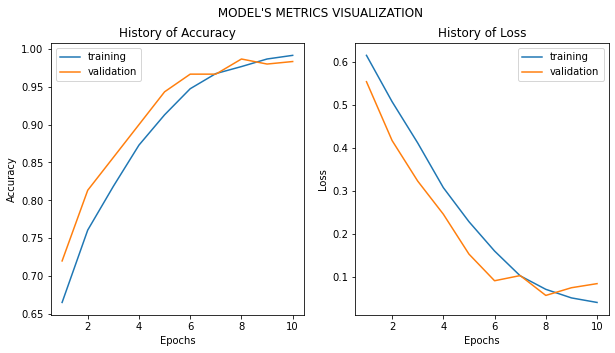

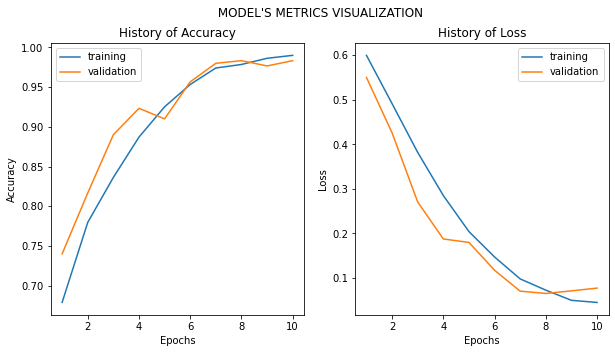

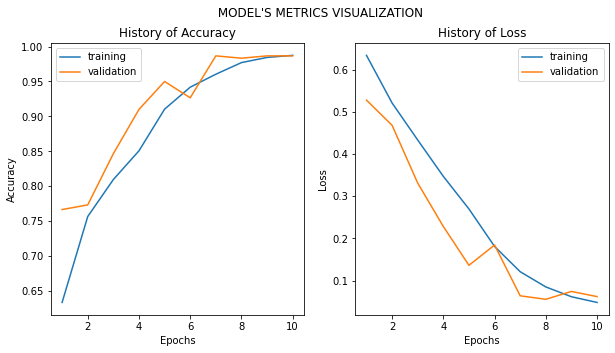

In [8]:
#%% LOOKING AT THE ACCURACY-LOSS PLOTS FOR EACH FOLD

def Acc_Loss_Plot(results):
    
    for fold in results:
        
        acc = fold.history['acc']
        val_acc = fold.history['val_acc']
        loss = fold.history['loss']
        val_loss = fold.history['val_loss']
    
        fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

        ax1.plot(range(1, len(acc) + 1), acc)
        ax1.plot(range(1, len(val_acc) + 1), val_acc)
        ax1.set_title('History of Accuracy')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend(['training', 'validation'])


        ax2.plot(range(1, len(loss) + 1), loss)
        ax2.plot(range(1, len(val_loss) + 1), val_loss)
        ax2.set_title('History of Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend(['training', 'validation'])
        plt.show()
    
Acc_Loss_Plot(cv_results)

In [9]:
#%% LOADING THE MODEL

import keras

keras_model = keras.models.load_model('Brain_model_best.h5')
keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                    loss='sparse_categorical_crossentropy', metrics =[ 'acc'])

# Predictions on the test set

datagen = ImageDataGenerator(rescale = 1./255)

test_set = datagen.flow_from_dataframe(df_test,
                                       directory = '//kaggle/input/brain-tumor-detection/*.jpg',
                                       x_col = 'image',
                                       y_col = None,
                                       target_size = size,
                                       color_mode = 'grayscale',
                                       class_mode = None,
                                       batch_size = 10,
                                       shuffle = False,
                                       interpolation = 'bilinear')

predictions = keras_model.predict(test_set)
predictions = predictions.argmax(axis=-1)
print("Where 0 = 'Affected'")
print("Where 1 = 'Healthy'")
print(predictions)


Found 60 validated image filenames.
Where 0 = 'Affected'
Where 1 = 'Healthy'
[1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0
 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 1]


In [10]:
pred = []
[pred.append('Healthy') if i == 1 else pred.append('Affected') for i in predictions]
print(pred)

['Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy', 'Healthy', 'Affected', 'Affected', 'Healthy']


In [11]:
#%% OBTAINING PREDICTIONS OF THE FIRST BATCH
    
images10 = [test_set[0][0],test_set[0][1],test_set[0][2],test_set[0][3],test_set[0][4],
            test_set[0][5],test_set[0][6],test_set[0][7],test_set[0][8],test_set[0][9]]
            
prediction10 = pred[0:9]
final_pred = zip(images10,prediction10)

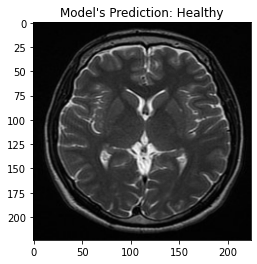

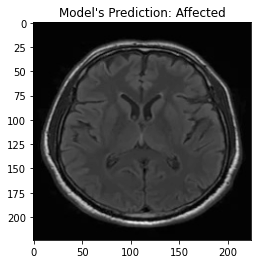

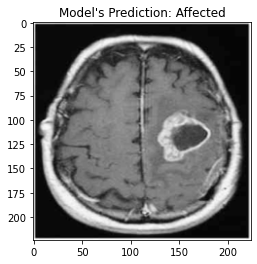

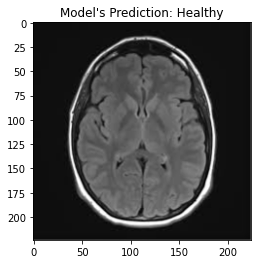

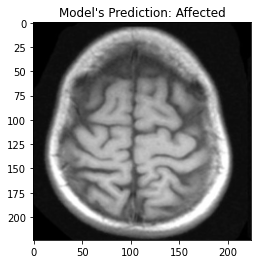

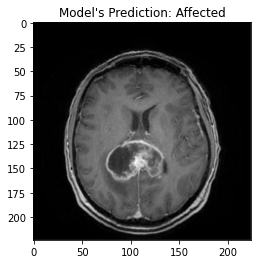

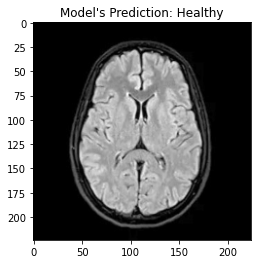

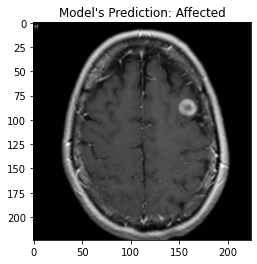

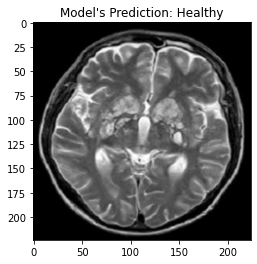

In [12]:
def pre_visualization(data, predictions):
    
    for image,pred in final_pred:
        plt.imshow(image.reshape(224,224), cmap = 'gray')
        plt.title("Model's Prediction: " + str(pred))
        plt.show()
        
pre_visualization(images10,prediction10)